## Tổng hợp chương trình của cả nhóm

### Random Forest - Nguyễn Văn Tuấn

In [8]:
import os
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from PIL import Image

# 1. Chuẩn bị mô hình ResNet50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet50 với trọng số từ ImageNet
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # Loại bỏ lớp cuối cùng
resnet.eval()

# Hàm tiền xử lý ảnh
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Hàm trích xuất đặc trưng từ ResNet50
def extract_features(image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        features = resnet(img_tensor)
    return features.squeeze().cpu().numpy().reshape(-1) # Sửa đổi ở đây

# 2. Chuẩn bị dữ liệu
def load_images_with_labels(folder):
    data = []
    labels = []
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        img = cv2.imread(filepath)
        if img is not None:
            # Gắn nhãn dựa trên tên file
            if "frog" in filename.lower():
                label = 0  # Ếch không gây hại
            elif "rat" in filename.lower():
                label = 1  # Chuột gây hại
            elif "grasshopper" in filename.lower():
                label = 2  # Châu chấu gây hại
            else:
                continue  # Bỏ qua file không hợp lệ
            
            # Trích xuất đặc trưng
            features = extract_features(filepath)
            data.append(features)
            labels.append(label)
    return np.array(data), np.array(labels)

# Đường dẫn tới folder chứa tất cả ảnh
data_folder = "/home/ultimatebrok/Documents/image/animaldata/final_dataset"

# Load dữ liệu và đo thời gian
print("Đang load dữ liệu...")
frog_data, frog_labels = load_data(frog_folder, 0)
grasshopper_data, grasshopper_labels = load_data(grasshopper_folder, 1)
mouse_data, mouse_labels = load_data(rat_folder, 2)

# Gộp tất cả dữ liệu
X = np.vstack((frog_data, grasshopper_data, mouse_data))
y = np.hstack((frog_labels, grasshopper_labels, mouse_labels))

# Chia tập dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Huấn luyện mô hình Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Đánh giá mô hình
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác của mô hình: {accuracy * 100:.2f}%")

# 6. Dự đoán trên ảnh mới
def predict_image(image_path):
    features = extract_features(image_path).reshape(1, -1)
    prediction = model.predict(features)[0]
    if prediction == 0:
        return "Ếch - Không nguy hại"
    elif prediction == 1:
        return "Chuột - Nguy hại"
    elif prediction == 2:
        return "Châu chấu - Nguy hại"

# Ví dụ dự đoán một ảnh mới
new_image_path = "/home/ultimatebrok/Documents/image/animaldata/final_dataset/frog/frog_129.jpeg"  # Đường dẫn tới ảnh cần dự đoán
result = predict_image(new_image_path)
print("Kết quả dự đoán:", result)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

## K-Nearest Neighbors - Trần Đình Trung

In [14]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
import time

# Hàm trích xuất đặc trưng từ ResNet
def extract_features(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        features = resnet(img_tensor)
    return features.squeeze().cpu().numpy()

# Load dữ liệu và trích xuất đặc trưng
def load_data(folder_path, label):
    data = []
    labels = []
    for file_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file_name)
        if img_path.endswith(('jpg', 'png', 'jpeg')):
            features = extract_features(img_path)
            data.append(features)
            labels.append(label)
    return np.array(data), np.array(labels)

# Hàm dự đoán loài và nguy hại
def predict_image(image_path):
    start = time.time()
    features = extract_features(image_path).reshape(1, -1)
    label = knn.predict(features)[0]
    end = time.time()
    if label == 0:
        return "Ếch - Không nguy hại"
    elif label == 1:
        return "Châu chấu - Nguy hại"
    elif label == 2:
        return "Chuột - Nguy hại"

# Kiểm tra xem GPU có sẵn hay không, nếu không thì dùng CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sử dụng weights thay vì pretrained
weights = ResNet50_Weights.IMAGENET1K_V1
resnet = resnet50(weights=weights).to(device)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # Bỏ lớp cuối
resnet.eval()

# Hàm tiền xử lý ảnh
transform = transforms.Compose([
    transforms.ToPILImage(),  # Chuyển từ OpenCV numpy array sang PIL Image
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Đo thời gian bắt đầu
start_time = time.time()

# Đường dẫn đến thư mục ảnh
frog_folder = "/home/ultimatebrok/Documents/image/animaldata/final_dataset/frog"
grasshopper_folder = "/home/ultimatebrok/Documents/image/animaldata/final_dataset/grasshopper"
rat_folder = "/home/ultimatebrok/Documents/image/animaldata/final_dataset/rat"

# Load dữ liệu và đo thời gian
print("Đang load dữ liệu...")
frog_data, frog_labels = load_data(frog_folder, 0)
grasshopper_data, grasshopper_labels = load_data(grasshopper_folder, 1)
mouse_data, mouse_labels = load_data(rat_folder, 2)

# Gộp tất cả dữ liệu
X = np.vstack((frog_data, grasshopper_data, mouse_data))
y = np.hstack((frog_labels, grasshopper_labels, mouse_labels))

# Chia tập dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Kiểm tra và dự đoán
y_pred = knn.predict(X_test)
print("Độ chính xác:", round(accuracy_score(y_test, y_pred), 2))

# Ví dụ
print(predict_image("/home/ultimatebrok/Documents/image/animaldata/final_dataset/rat/rat_11.jpeg"))

# Tổng thời gian
total_time = time.time() - start_time
print(f"Tổng thời gian chạy chương trình: {total_time:.2f} giây")

Đang load dữ liệu...
Độ chính xác: 0.99
Chuột - Nguy hại
Tổng thời gian chạy chương trình: 27.04 giây


## Naive Bayes - Nguyễn Đức Hiếu

Số lượng ảnh: 450
Số lượng nhãn: 450
Kích thước mỗi ảnh (sau khi flatten): (65536,)
Các nhãn: [0 1 2]


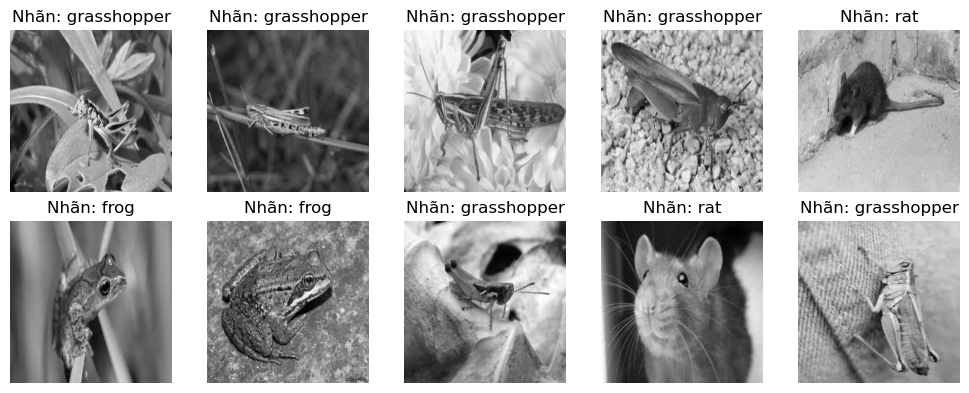

Độ chính xác: 0.5333333333333333

Báo cáo phân loại:
              precision    recall  f1-score   support

        frog       0.55      0.80      0.65        35
 grasshopper       0.45      0.61      0.52        23
         rat       0.75      0.19      0.30        32

    accuracy                           0.53        90
   macro avg       0.58      0.53      0.49        90
weighted avg       0.60      0.53      0.49        90


Confusion Matrix:
[[28  7  0]
 [ 7 14  2]
 [16 10  6]]


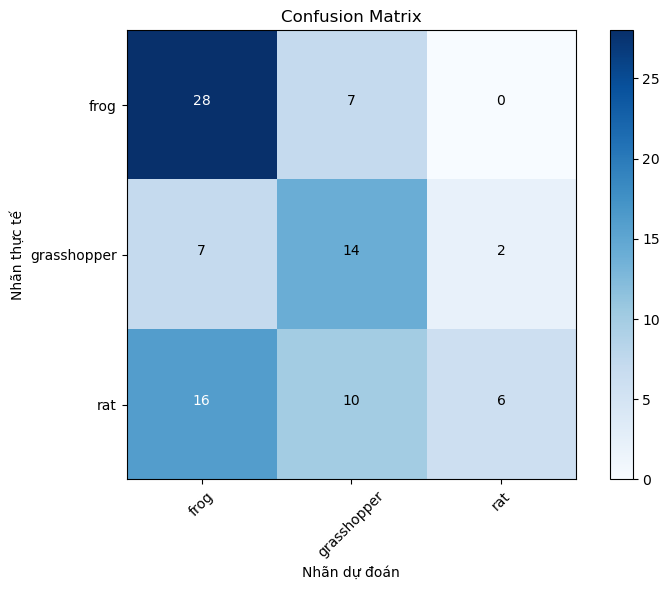

Các nhãn có hại/không có hại: ['có hại' 'không có hại']
Ảnh thứ: 32
Nhãn dự đoán: rat
Nhãn thực tế: rat
Có hại/không có hại (dự đoán): có hại
Có hại/không có hại (thực tế): có hại
Dự đoán loài: Đúng
Dự đoán có hại/không có hại: Đúng
------------------------------
Ảnh thứ: 74
Nhãn dự đoán: rat
Nhãn thực tế: rat
Có hại/không có hại (dự đoán): có hại
Có hại/không có hại (thực tế): có hại
Dự đoán loài: Đúng
Dự đoán có hại/không có hại: Đúng
------------------------------
Ảnh thứ: 9
Nhãn dự đoán: grasshopper
Nhãn thực tế: grasshopper
Có hại/không có hại (dự đoán): có hại
Có hại/không có hại (thực tế): có hại
Dự đoán loài: Đúng
Dự đoán có hại/không có hại: Đúng
------------------------------
Ảnh thứ: 26
Nhãn dự đoán: grasshopper
Nhãn thực tế: rat
Có hại/không có hại (dự đoán): có hại
Có hại/không có hại (thực tế): có hại
Dự đoán loài: Sai
Dự đoán có hại/không có hại: Đúng
------------------------------
Ảnh thứ: 73
Nhãn dự đoán: rat
Nhãn thực tế: grasshopper
Có hại/không có hại (dự đoán): có 

In [17]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import random

# Cài đặt đường dẫn
data_dir = "/home/ultimatebrok/Documents/image/animaldata/final_dataset/"
classes = ["frog", "grasshopper", "rat"]
img_size = 256

# Hàm hỗ trợ
def load_and_preprocess_image(image_path):
    """Tải ảnh, chuyển về ảnh xám và resize."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    return cv2.resize(img, (img_size, img_size))

# 1. Thu thập và tiền xử lý dữ liệu
data = []
labels = []

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        img = load_and_preprocess_image(image_path)
        if img is not None:
            data.append(img.flatten())  # Chuyển ảnh 2D thành vector 1D
            labels.append(classes.index(class_name))

data = np.array(data)
labels = np.array(labels)

# 2. Tìm hiểu tập dữ liệu
print("Số lượng ảnh:", len(data))
print("Số lượng nhãn:", len(labels))
print("Kích thước mỗi ảnh (sau khi flatten):", data[0].shape)
print("Các nhãn:", np.unique(labels))

# Hiển thị một số ảnh mẫu
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    random_index = random.randint(0, len(data) - 1)
    ax.imshow(data[random_index].reshape(img_size, img_size), cmap='gray')
    ax.set_title(f"Nhãn: {classes[labels[random_index]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# 3. Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# 4. Huấn luyện mô hình Naive Bayes
model = GaussianNB()
model.fit(X_train, y_train)

# 5. Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# 6. Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print("Độ chính xác:", accuracy)

print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred, target_names=classes))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Hiển thị confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Nhãn thực tế')
plt.xlabel('Nhãn dự đoán')
plt.tight_layout()
plt.show()

# 7. Thêm nhãn "có hại/không có hại" và hàm check_prediction

# Thêm nhãn "có hại/không có hại"
harmful_labels = []
for label in labels:
    if classes[label] == "frog":
        harmful_labels.append("không có hại")
    else:
        harmful_labels.append("có hại")
harmful_labels = np.array(harmful_labels)

# Chia tập dữ liệu harmful_labels
y_harmful_train, y_harmful_test = train_test_split(harmful_labels, test_size=0.2, random_state=42)

print("Các nhãn có hại/không có hại:", np.unique(harmful_labels))

# Hàm kiểm tra dự đoán và xác nhận đúng/sai
def check_prediction(index, model, X_test, y_test, y_harmful_test, classes):
    """Kiểm tra dự đoán của mô hình cho ảnh tại vị trí 'index'."""
    prediction = model.predict(X_test[index].reshape(1, -1))[0]
    true_label = y_test[index]
    true_harmful_label = y_harmful_test[index]

    print(f"Ảnh thứ: {index}")
    print(f"Nhãn dự đoán: {classes[prediction]}")
    print(f"Nhãn thực tế: {classes[true_label]}")
    print(f"Có hại/không có hại (dự đoán): {'có hại' if classes[prediction] != 'frog' else 'không có hại'}")
    print(f"Có hại/không có hại (thực tế): {true_harmful_label}")

    # Kiểm tra độ chính xác dự đoán loài
    if prediction == true_label:
        print("Dự đoán loài: Đúng")
    else:
        print("Dự đoán loài: Sai")
    
    # Kiểm tra độ chính xác dự đoán có hại/không có hại
    predicted_harmful_label = "có hại" if classes[prediction] != "frog" else "không có hại"
    if predicted_harmful_label == true_harmful_label:
        print("Dự đoán có hại/không có hại: Đúng")
    else:
        print("Dự đoán có hại/không có hại: Sai")

    print("-" * 30)

# Thử nghiệm với hàm check_prediction
for i in range(5):
    random_index = random.randint(0, len(X_test) - 1)
    check_prediction(random_index, model, X_test, y_test, y_harmful_test, classes)